# Search Algorithms

In [4]:
from overrides import overrides
import torch
from torch import nn
import numpy as np
import json
from typing import Tuple
from random import Random

from typing import Tuple, List, Optional
from archai.discrete_search import ArchaiModel, EvolutionarySearchSpace, BayesOptSearchSpace

We will re-use the CNN search space created in the [search space example](./search_space.ipynb).

In [5]:
class MyModel(nn.Module):
    def __init__(self, nb_layers: int = 5, kernel_size: int = 3, hidden_dim: int = 32):
        super().__init__()
        
        self.nb_layers = nb_layers
        self.kernel_size = kernel_size
        self.hidden_dim = hidden_dim
        
        layer_list = []

        for i in range(nb_layers):
            in_ch = (1 if i == 0 else hidden_dim)
            
            layer_list += [
                nn.Conv2d(in_ch, hidden_dim, kernel_size=kernel_size, padding=(kernel_size-1)//2),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU(),
            ]
            
        layer_list += [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            nn.Conv2d(hidden_dim, 10, kernel_size=1)
        ]

        self.model = nn.Sequential(*layer_list)
    
    def forward(self, x):
        return self.model(x).squeeze()
    
    def get_archid(self):
        return f'({self.nb_layers}, {self.kernel_size}, {self.hidden_dim})'

In [6]:
class CNNSearchSpace(EvolutionarySearchSpace, BayesOptSearchSpace):
    def __init__(self, min_layers: int = 1, max_layers: int = 12,
                 kernel_list=(1, 3, 5, 7), hidden_list=(16, 32, 64, 128),
                 seed: int = 1):

        self.min_layers = min_layers
        self.max_layers = max_layers
        self.kernel_list = kernel_list
        self.hidden_list = hidden_list
        
        self.rng = Random(seed)
        
    @overrides
    def random_sample(self) -> ArchaiModel:
        # Randomly chooses architecture parameters
        nb_layers = self.rng.randint(self.min_layers, self.max_layers)
        kernel_size = self.rng.choice(self.kernel_list)
        hidden_dim = self.rng.choice(self.hidden_list)
        
        model = MyModel(nb_layers, kernel_size, hidden_dim)
        
        # Wraps model into ArchaiModel
        return ArchaiModel(arch=model, archid=model.get_archid())

    @overrides
    def save_arch(self, model: ArchaiModel, file: str):
        with open(file, 'w') as fp:
            json.dump({
                'nb_layers': model.arch.nb_layers,
                'kernel_size': model.arch.kernel_size,
                'hidden_dim': model.arch.hidden_dim
            }, fp)

    @overrides
    def load_arch(self, file: str):
        config = json.load(open(file))
        model = MyModel(**config)
        
        return ArchaiModel(arch=model, archid=model.get_archid())

    @overrides
    def save_model_weights(self, model: ArchaiModel, file: str):
        state_dict = model.arch.get_state_dict()
        torch.save(state_dict, file)
    
    @overrides
    def load_model_weights(self, model: ArchaiModel, file: str):
        model.arch.load_state_dict(torch.load(file))

    @overrides
    def mutate(self, model_1: ArchaiModel) -> ArchaiModel:
        config = {
            'nb_layers': model_1.arch.nb_layers,
            'kernel_size': model_1.arch.kernel_size,
            'hidden_dim': model_1.arch.hidden_dim
        }
        
        if self.rng.random() < 0.2:
            config['nb_layers'] = self.rng.randint(self.min_layers, self.max_layers)
        
        if self.rng.random() < 0.2:
            config['kernel_size'] = self.rng.choice(self.kernel_list)
        
        if self.rng.random() < 0.2:
            config['hidden_dim'] = self.rng.choice(self.hidden_list)
        
        mutated_model = MyModel(**config)
        
        return ArchaiModel(
            arch=mutated_model, archid=mutated_model.get_archid()
        )
    
    @overrides
    def crossover(self, model_list: List[ArchaiModel]) -> ArchaiModel:
        model_1, model_2 = model_list[:2]
        
        new_config = {
            'nb_layers': self.rng.choice([model_1.arch.nb_layers, model_2.arch.nb_layers]),
            'kernel_size': self.rng.choice([model_1.arch.kernel_size, model_2.arch.kernel_size]),
            'hidden_dim': self.rng.choice([model_1.arch.hidden_dim, model_2.arch.hidden_dim]),
        }
        
        crossover_model = MyModel(**new_config)
        
        return ArchaiModel(
            arch=crossover_model, archid=crossover_model.get_archid()
        )
    
    @overrides
    def encode(self, model: ArchaiModel) -> np.ndarray:
        return np.array([model.arch.nb_layers, model.arch.kernel_size, model.arch.hidden_dim])

In [7]:
ss = CNNSearchSpace(max_layers=10, kernel_list=[3, 5, 7], hidden_list=[32, 64, 128])

In [8]:
m = ss.random_sample()
m

ArchaiModel(
	archid=(3, 7, 32), 
	metadata={}, 
	arch=MyModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
    (10): Conv2d(32, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)
)

## Dataset Provider

Datasets are represented in Archai throught the [`DatasetProvider`](../../reference/api/archai.discrete_search.api.rst) class. For this example, we will use the built-in dataset provider of the MNIST dataset.

In [9]:
from pathlib import Path
from archai.cv.datasets.providers.mnist_provider import MnistProvider

In [10]:
dataset_provider = MnistProvider({'dataroot': Path.home() / 'dataroot'})

We can get train/test PyTorch datasets from a DatasetProvider by calling `dataset_provider.get_datasets(load_train, load_test, transforms_train, transforms_test)`

In [11]:
# Loads only the training set
tr_d, _ = dataset_provider.get_datasets(load_train=True, load_test=False, transform_train=None, transform_test=None)

## Wrapping custom evaluation code

We will evaluate our models using partial trainig validation accuracy as a proxy for final task performance. 

In [12]:
from archai.discrete_search import ModelEvaluator
from archai.discrete_search.evaluators.ray import RayParallelEvaluator

from torchvision.transforms import Compose, ToTensor, Normalize
from tqdm import tqdm
import math


class PartialTrainingValAccuracy(ModelEvaluator):
    def __init__(self, training_epochs: float = 1.0, lr: float = 1e-4, device: str = 'cpu',
                 progress_bar: bool = False):
        self.training_epochs = training_epochs
        self.device = device
        self.lr = lr
        self.preprocess = ToTensor()
        self.progress_bar = progress_bar
    
    @overrides
    def evaluate(self, model, dataset_provider, budget = None) -> float:
        # Loads the dataset
        tr_data, _ = dataset_provider.get_datasets(True, False, self.preprocess, None)
        
        # Train-validation split
        tr_data, val_data = torch.utils.data.random_split(
            tr_data, lengths=[len(tr_data) - 1_000, 1_000], 
            generator=torch.Generator().manual_seed(42)
        )
        
        tr_dl = torch.utils.data.DataLoader(tr_data, batch_size=16, shuffle=True, num_workers=4)
        val_dl = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False, num_workers=4)
        
        # Training settings
        optimizer = torch.optim.Adam(model.arch.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        model.arch.train()
        model.arch.to(self.device)
        
        # Partial training
        epoch_iter = range(math.ceil(self.training_epochs))
        if self.progress_bar:
            epoch_iter = tqdm(epoch_iter, desc=f'Training model {model.archid}')

        for epoch_nb in epoch_iter:
            # Early stops for fractional values of training epochs (e.g, 0.2)
            early_stop = len(tr_dl) + 1
            if 0 < (self.training_epochs - epoch_nb) < 1:
                early_stop = int((self.training_epochs - epoch_nb) * len(tr_dl))
            
            for i, (x, y) in enumerate(tr_dl):
                if i >= early_stop:
                    break
                
                optimizer.zero_grad()
                
                pred = model.arch(x.to(self.device))
                loss = criterion(pred, y.to(self.device))

                loss.backward()
                optimizer.step()
        
        # Evaluates final model
        model.arch.eval()
        
        with torch.no_grad():
            val_pred, val_target = [], []

            for x, y in val_dl:
                val_pred.append(model.arch(x.to(self.device)).argmax(axis=1).to('cpu'))
                val_target.append(y.to('cpu'))

            val_pred, val_target = torch.cat(val_pred, axis=0), torch.cat(val_target, axis=0)
            val_acc = (val_pred.squeeze() == val_target.squeeze()).numpy().mean()

        # Returns model to cpu
        model.arch.cpu()
        
        return val_acc

Let's test our evaluator:

In [13]:
partial_tr = PartialTrainingValAccuracy(training_epochs=0.001, progress_bar=True)

In [14]:
partial_tr.evaluate(ss.random_sample(), dataset_provider)

Training model (5, 3, 64): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


0.088

We can make this objective more efficient evaluating multiple architectures in parallel. To do that, we can use the `RayParallelObjective` wrapper mentioned in the [previous example](./objectives.ipynb):

In [15]:
parallel_partial_tr = RayParallelEvaluator(partial_tr)

Let's test our partial training objective sending two random architectures

In [16]:
# NBVAL_SKIP
parallel_partial_tr.send(ss.random_sample(), dataset_provider)
parallel_partial_tr.send(ss.random_sample(), dataset_provider)

2023-01-10 16:51:28,677	INFO worker.py:1518 -- Started a local Ray instance.


In [17]:
# NBVAL_SKIP
parallel_partial_tr.fetch_all()

Training model (8, 5, 128): 100%|██████████| 1/1 [00:07<00:00,  7.10s/it]


[0.088, 0.088]

To run the same objective distributing jobs across multiple GPUs, just set the `num_gpus` parameter from [ray.init](https://docs.ray.io/en/latest/ray-core/package-ref.html#ray-init):

```python
RayParallelObjective(
    PartialTrainingValAccuracy(training_epochs=1),
    num_gpus=0.5, # 2 jobs per gpu available
    max_calls=1
)
```

## Defining Search Objectives

Search optimization objectives are specified using the `archai.discrete_search.SearchObjectives` class

In [18]:
from archai.discrete_search import SearchObjectives

objectives = SearchObjectives()

### Adding objectives

To add search objectives, we can use the `SearchObjectives.add_objective` method


In [20]:
from archai.discrete_search.evaluators.onnx_model import AvgOnnxLatency
from archai.discrete_search.evaluators.torch_profiler import TorchFlops, TorchNumParameters

objectives.add_objective(
    # This name will be used in plots and reports
    name='ONNX Latency (ms)',  
    
    # This is the evaluator we want to use
    model_evaluator=AvgOnnxLatency(input_shape=(1, 1, 28, 28), num_trials=3),  
    
    # Optimization direction. `True` for maximization or `False` for minimization
    higher_is_better=False,

    # Used to sinalized if this evaluator is compute intensive.
    compute_intensive=False 
)


The `compute_intensive` flag is used in some search algorithms to help increase search efficiency. For instance, search algorithms that use surrogate models may try to estimate the value of expensive objective functions of unseen architectures in certain situations, while cheap objectives (`compute_intensive=False`) will just be computed directly.

In [22]:
objectives.add_objective(
    'FLOPs', TorchFlops(sample_args=(torch.randn(1, 1, 28, 28),)),
    higher_is_better=False,
    compute_intensive=False,
    # We may optionally add a constraint. 
    # Architectures outside this range will be ignored by the search algorithm
    constraint=(0.0, 1e9)
)

Additionally, objectives that are cheap to evaluate (`compute_intensive=False`) may receive an optional `constraint` argument. Model candidates outside this range will
be ignored by the search algorithm.

We can evaluate cheap objectives calling `SearchObjectives.eval_cheap_objs(model_list, dataset_providers)`

In [23]:
objectives.eval_cheap_objs([ss.random_sample() for _ in range(2)], dataset_providers=None,
                           progress_bar=True)

Calculating "FLOPs"...: 100%|██████████| 2/2 [00:00<00:00, 20.09it/s]
Gathering results from async objectives...: 0it [00:00, ?it/s]


{'ONNX Latency (ms)': array([0.00098251, 0.00145262]),
 'FLOPs': array([4.07179530e+08, 4.75242634e+08])}

We can check if a model satisfies the constraints we added for the FLOPs objective by calling `SearchObjectives.validate_constraints(model_list, dataset_providers)` or `SearchObjectives.is_model_valid(ss.random_sample(), dataset_provider)`

In [24]:
m = ss.random_sample()

objectives.validate_constraints([m], dataset_providers=None)

({'FLOPs': array([4.50410139e+09])}, array([], dtype=int64))

In [25]:
objectives.is_model_valid(m, dataset_provider=None)

False

By default, all objective and constraints evaluations are cached to prevent spending resources in the same architecture twice.

In [26]:
# The evaluation cached is built
# using the tuple (obj_name, archid, dataset provider name, budget)
objectives.cache

{('ONNX Latency (ms)', '(8, 3, 64)', 'NoneType', None): 0.0009825120214372873,
 ('ONNX Latency (ms)', '(7, 7, 32)', 'NoneType', None): 0.001452620994920532,
 ('FLOPs', '(8, 3, 64)', 'NoneType', None): 407179530,
 ('FLOPs', '(7, 7, 32)', 'NoneType', None): 475242634,
 ('FLOPs', '(8, 5, 128)', 'NoneType', None): 4504101386}

Caching can be disabled setting `SearchObjectives(cache_objective_evaluation=False)`.

Now, let's add the partial training objective we created before

In [28]:
objectives.add_objective(
    'Partial training Validation Accuracy (1 epoch)',
    RayParallelEvaluator(
        PartialTrainingValAccuracy(training_epochs=1, device='cuda'),
        num_gpus=0.5, # 2 jobs per gpu available
        max_calls=1
    ),
    higher_is_better=True,
    compute_intensive=True # This is a compute intensive evaluator
)

Expensive objectives can be evaluated using `SearchObjectives.eval_expensive_objs(model_list, dataset_providers)`

Alternatively, all objectives (expensive and cheap) can also be evaluated using `SearchObjectives.eval_all_objs`.

### Adding extra constraints

Besides the constraint parameter from cheap objectives, it is also possible to add extra constraints that are not search objectives (and thus should not be optimized by NAS algorithms).

In [31]:
from archai.discrete_search.evaluators.torch_profiler import TorchNumParameters

objectives.add_constraint(
    'Number of parameters',
    TorchNumParameters(),
    constraint=(0.0, 1e6)
)

In [32]:
objectives.validate_constraints([m], None)

({'Number of parameters': array([2874762.]), 'FLOPs': array([4.50410139e+09])},
 array([], dtype=int64))

In [33]:
objectives.is_model_valid(m, None)

False

## Using a search algorithm

Now that we know how to create and use search objectives, we can finally use a search algorithm do to Neural Architecture Search!

### Example: `EvolutionParetoSearch`

Let's start with an evolutionary-based search algorithm

In [34]:
from archai.discrete_search.algos.evolution_pareto import EvolutionParetoSearch

In [35]:
algo = EvolutionParetoSearch(
    ss, objectives, dataset_provider, 
    output_dir='./out_evo',
    num_iters=5, num_crossovers=5,
    mutations_per_parent=2,
    max_unseen_population=10
)

In [28]:
# NBVAL_SKIP
search_results = algo.search()

13:56 Using 10 random architectures as the initial population
13:56 starting evolution pareto iter 0
13:56 iter 0: calculating search objectives ['ONNX Latency (ms)', 'FLOPs', 'Partial training Validation Accuracy (1 epoch)'] for 10 models
13:57 iter 0: updating the pareto
13:57 iter 0: found 7 members
13:57 iter 0: chose 7 parents
Mutating parents: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 25.16it/s]
13:57 iter 0: mutation yielded 12 new models
13:57 iter 0: crossover yielded 1 new models
13:57 iter 0: total unseen population 18
13:57 iter 0: total unseen population after `max_unseen_population` restriction 10
13:57 starting evolution pareto iter 1
13:57 iter 1: calculating search objectives ['ONNX Latency (ms)', 'FLOPs', 'Partial training Validation Accuracy (1 epoch)'] for 10 models
13:58 iter 1: updating the pareto
13:58 iter 1: found 12 member

By default all algorithms will save the final pareto architectures `{output_dir}/pareto_models_iter_*/`, pareto evolution plots `pareto_*.png` and search state tables with all the results `{output_dir}/search_state_*.csv`

In [29]:
# NBVAL_SKIP
!ls ./out_evo

log.log
pareto_FLOPs_vs_Partial_training_Validation_Accuracy_1_epoch.png
pareto_models_iter_1
pareto_models_iter_2
pareto_models_iter_3
pareto_models_iter_4
pareto_models_iter_5
pareto_ONNX_Latency_ms_vs_FLOPs.png
pareto_ONNX_Latency_ms_vs_Partial_training_Validation_Accuracy_1_epoch.png
search_state_1.csv
search_state_2.csv
search_state_3.csv
search_state_4.csv
search_state_5.csv


It is also possible to get information from the `search_results` object directly:

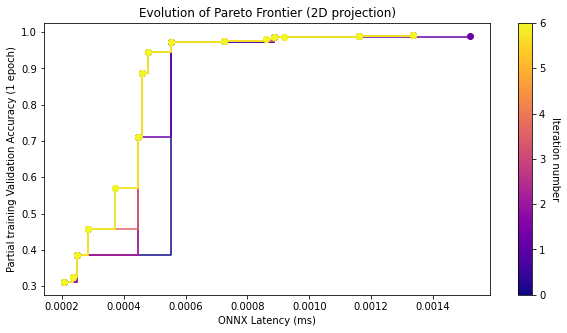

In [30]:
# NBVAL_SKIP
search_results.plot_2d_pareto_evolution(('ONNX Latency (ms)', 'Partial training Validation Accuracy (1 epoch)'))

In [31]:
# NBVAL_SKIP
search_results.get_search_state_df().query('is_pareto').sort_values('Partial training Validation Accuracy (1 epoch)')

,archid,Partial training Validation Accuracy (1 epoch),ONNX Latency (ms),FLOPs,parent,parents,iteration_num,Search walltime (hours),is_pareto
46,"(1, 3, 64)",0.264,0.000239,706762.0,"(1, 7, 128)",None,4,0.086072,True
10,"(1, 5, 32)",0.274,0.000251,754794.0,"(1, 5, 128)",None,1,0.032674,True
4,"(1, 7, 32)",0.310,0.000208,1356906.0,None,None,0,0.016957,True
35,"(1, 7, 64)",0.326,0.000236,2713802.0,"(9, 3, 64)",None,3,0.070278,True
7,"(1, 5, 128)",0.335,0.000296,3019146.0,None,None,0,0.016957,True
2,"(1, 7, 128)",0.385,0.000249,5427594.0,None,None,0,0.016957,True
39,"(2, 3, 32)",0.456,0.000285,7679082.0,"(9, 3, 32)",None,3,0.070278,True
48,"(2, 3, 64)",0.569,0.000370,29808842.0,"(2, 3, 32)",None,4,0.086072,True
15,"(3, 3, 32)",0.710,0.000445,15004778.0,"(6, 3, 32)",None,1,0.032674,True
22,"(4, 3, 32)",0.829,0.000490,22330474.0,"(6, 3, 32)",None,2,0.052575,True


Since our search space is also compatible with Bayesian Optimization algorithms, let's try more sophisticated algorithm like MO-BANANAS. 

MO-BANANAS will progressively train a surrogate model based on the data gathered during search. This surrogate model will be used to predict the result of expensive objective function evaluations and will try to determine what are the best possible architectures according to the surrogate model.

In [36]:
from archai.discrete_search.algos.bananas import MoBananasSearch

In [37]:
algo2 = MoBananasSearch(
    ss, objectives, dataset_provider, 
    output_dir='./out_bananas', 
    num_iters=5, mutations_per_parent=5,
    num_candidates=20
)

In [34]:
# NBVAL_SKIP
search_results2 = algo2.search()

14:01 Starting iteration 0
14:01 Evaluating objectives for 10 architectures
14:02 Updating surrogate model...
Training DNN Ensemble...: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:26<00:00,  5.39s/it]
/home/pkauffmann/archai/archai/discrete_search/utils/multi_objective.py:53: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  frontiers = np.array(
14:02 Generating mutations for 10 parent architectures...
14:02 Found 36 new architectures satisfying constraints.
14:02 Predicting ['Partial training Validation Accuracy (1 epoch)'] for new architectures using surrogate model
14:02 Calculating cheap objectives {'ONNX Latency (ms)': {'objective': <archai.discret

In [35]:
# NBVAL_SKIP
!ls ./out_bananas

log.log
pareto_FLOPs_vs_Partial_training_Validation_Accuracy_1_epoch.png
pareto_ONNX_Latency_ms_vs_FLOPs.png
pareto_ONNX_Latency_ms_vs_Partial_training_Validation_Accuracy_1_epoch.png
search_state_0.csv
search_state_1.csv
search_state_2.csv
search_state_3.csv
search_state_4.csv


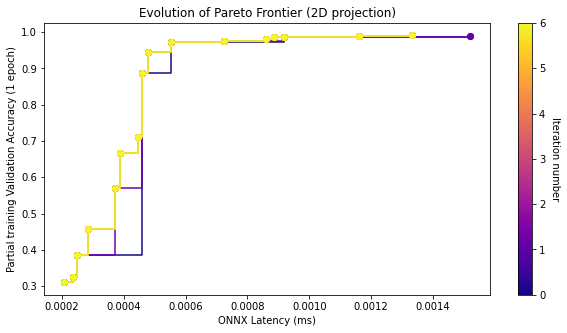

In [37]:
# NBVAL_SKIP
search_results2.plot_2d_pareto_evolution(('ONNX Latency (ms)', 'Partial training Validation Accuracy (1 epoch)'))

MO-BANANAS will also save the predictive mean and variance of the expensive objectives during that iteration .

In [36]:
# NBVAL_SKIP
search_results2.get_search_state_df().query('is_pareto').sort_values('Partial training Validation Accuracy (1 epoch)')

,archid,Partial training Validation Accuracy (1 epoch),ONNX Latency (ms),FLOPs,iteration_num,Predicted Partial training Validation Accuracy (1 epoch) mean,Predicted Partial training Validation Accuracy (1 epoch) var,Search walltime (hours),is_pareto
37,"(1, 3, 32)",0.248,0.000254,353386.0,2,0.248418,2.047968e-03,0.059447,True
16,"(1, 3, 64)",0.264,0.000239,706762.0,1,0.520867,2.725258e-04,0.035050,True
10,"(1, 5, 32)",0.274,0.000251,754794.0,1,0.524827,2.408193e-03,0.035050,True
19,"(1, 7, 32)",0.310,0.000208,1356906.0,1,0.750090,2.623198e-04,0.035050,True
26,"(1, 7, 64)",0.326,0.000236,2713802.0,1,0.558949,1.281874e-03,0.035050,True
32,"(1, 5, 128)",0.335,0.000296,3019146.0,2,0.305024,7.075308e-04,0.059447,True
2,"(1, 7, 128)",0.385,0.000249,5427594.0,0,NaN,NaN,0.009741,True
36,"(2, 3, 32)",0.456,0.000285,7679082.0,2,0.459846,1.940939e-03,0.059447,True
28,"(2, 3, 64)",0.569,0.000370,29808842.0,1,0.693631,3.133334e-05,0.035050,True
35,"(2, 5, 32)",0.666,0.000389,20925546.0,2,0.607475,8.238424e-04,0.059447,True
